In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
# Define the normalize_string function
import tensorflow as tf

def normalize_string(text):
    text = tf.strings.lower(text)  # Convert to lowercase
    text = tf.strings.regex_replace(text, r"[^\w\s]", "")  # Remove punctuation
    text = tf.strings.strip(text)  # Remove extra spaces
    return text

In [3]:
# Seed everything for reproducibility
from tensorflow.keras.utils import set_random_seed
set_random_seed(1)

# Install opendatasets to download the dataset from Kaggle
!pip install opendatasets

import opendatasets as od

# Download the Emotion dataset from Kaggle
od.download("https://www.kaggle.com/datasets/parulpandey/emotion-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: YOUR_KAGGLE_USERNAM
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/parulpandey/emotion-dataset


100%|██████████| 715k/715k [00:00<00:00, 75.5MB/s]

In [4]:
import pickle
import pandas as pd

df_train = pd.read_csv('emotion-dataset/training.csv')
df_test = pd.read_csv('emotion-dataset/test.csv')

In [5]:
# Check the column names of the training dataset
print(df_train.columns)

# Check the column names of the test dataset
print(df_test.columns)


Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


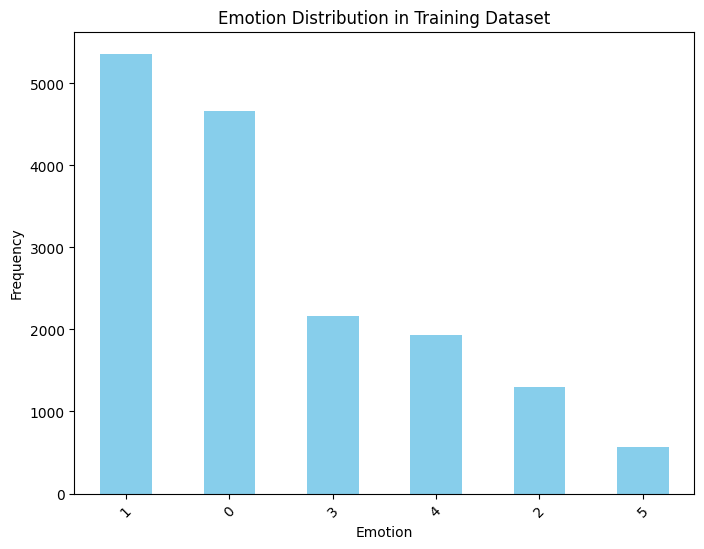

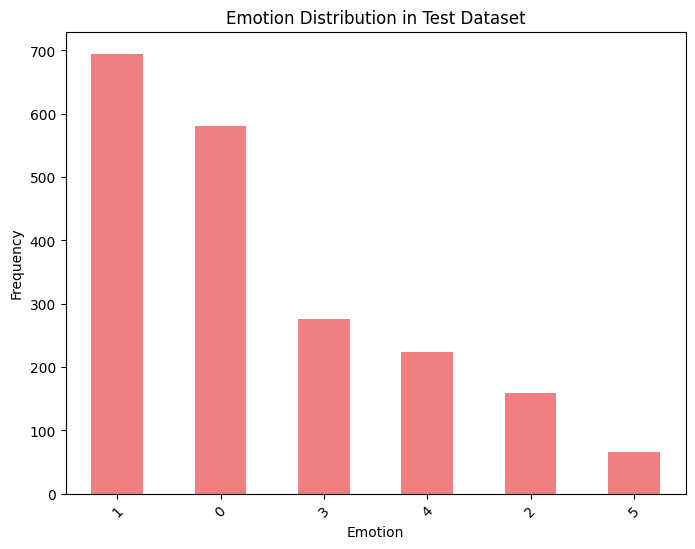

In [6]:
import matplotlib.pyplot as plt

# Plot the histogram of emotions (label) for the training dataset
plt.figure(figsize=(8, 6))
df_train['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution in Training Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot the histogram of emotions (label) for the test dataset
plt.figure(figsize=(8, 6))
df_test['label'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Emotion Distribution in Test Dataset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()



In [7]:
# One-hot encode the 'label' column in the training dataset
df_train = pd.get_dummies(df_train, columns=['label'])
df_train.head()

# One-hot encode the 'label' column in the test dataset
df_test = pd.get_dummies(df_test, columns=['label'])
df_test.head()


,text,label_0,label_1,label_2,label_3,label_4,label_5
0,im feeling rather rotten so im not very ambiti...,True,False,False,False,False,False
1,im updating my blog because i feel shitty,True,False,False,False,False,False
2,i never make her separate from me because i do...,True,False,False,False,False,False
3,i left with my bouquet of red and yellow tulip...,False,True,False,False,False,False
4,i was feeling a little vain when i did this one,True,False,False,False,False,False


In [8]:
# Map for converting one-hot encoded labels back to string form
label_tostr = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}


In [9]:
from sklearn.model_selection import train_test_split

# Separate the data and labels for the training dataset
X_train = df_train['text'].values
y_train = df_train.drop(columns=['text']).values  # Drop 'text' to get the labels

# Separate the data and labels for the test dataset
X_test = df_test['text'].values
y_test = df_test.drop(columns=['text']).values  # Drop 'text' to get the labels

# Print the shapes of the datasets
print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("###########################################")
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)


Training Data Input Shape:  (16000,)
Training Data Output Shape:  (16000, 6)
###########################################
Testing Data Input Shape:  (2000,)
Testing Data Output Shape:  (2000, 6)


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Initialize the TextVectorization layer
vectorizer_layer = TextVectorization(
    max_tokens=20000, output_mode='int', output_sequence_length=100
)

# Convert X_train to a dataset (batching helps with large data)
train_text_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(64)

# Adapt the vectorizer (only do this once)
vectorizer_layer.adapt(train_text_dataset)

# Transform the training data
X_train_vectorized = vectorizer_layer(X_train)



In [11]:
X_test_vectorized = vectorizer_layer(X_test)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.backend import clear_session

# Get vocab size from the adapted TextVectorization layer
vocab_size = vectorizer_layer.vocabulary_size()  # Get vocab size from vectorizer
embed_dim = 128  # Embedding vector size
hidden_dim = 64  # Number of LSTM units
num_classes = y_train.shape[1]  # Number of output classes (based on labels)

clear_session()  # Clears previous models from memory

model = Sequential()

# Add the TextVectorization layer (used only for preprocessing, not inside the model)
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True))

# Add the LSTM layer (returns only the last output)
model.add(LSTM(hidden_dim))

# Fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer (number of classes)
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1947392   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 2001350 (7.63 MB)
Trainable params: 2001350 (7.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [13]:
history = model.fit(X_train_vectorized, y_train, epochs=10, batch_size=32, validation_data=(X_test_vectorized, y_test))


Epoch 1/10
500/500 [==============================] - 79s 138ms/step - loss: 1.1114 - accuracy: 0.5801 - val_loss: 0.4581 - val_accuracy: 0.8595
Epoch 2/10
500/500 [==============================] - 55s 110ms/step - loss: 0.3332 - accuracy: 0.8942 - val_loss: 0.3472 - val_accuracy: 0.8845
Epoch 3/10
500/500 [==============================] - 56s 112ms/step - loss: 0.1630 - accuracy: 0.9499 - val_loss: 0.2638 - val_accuracy: 0.9125
Epoch 4/10
500/500 [==============================] - 57s 115ms/step - loss: 0.1087 - accuracy: 0.9678 - val_loss: 0.2852 - val_accuracy: 0.9155
Epoch 5/10
500/500 [==============================] - 57s 115ms/step - loss: 0.0973 - accuracy: 0.9715 - val_loss: 0.2986 - val_accuracy: 0.9140
Epoch 6/10
500/500 [==============================] - 57s 114ms/step - loss: 0.0617 - accuracy: 0.9809 - val_loss: 0.3139 - val_accuracy: 0.9160
Epoch 7/10
500/500 [==============================] - 57s 114ms/step - loss: 0.0505 - accuracy: 0.9849 - val_loss: 0.3452 - val_ac

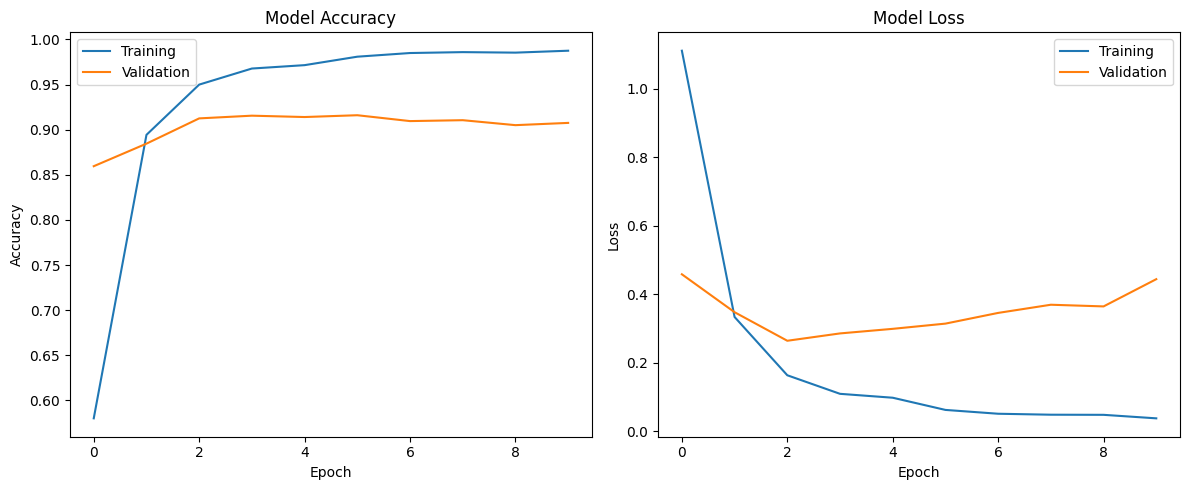

In [14]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Training', 'Validation'])

# Plot loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Training', 'Validation'])

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Get model predictions (probabilities)
y_pred_prob = model.predict(X_test_vectorized)

# Step 2: Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class indices

# Step 3: Print classification report
print(classification_report(y_true, y_pred))


63/63 [==============================] - 4s 25ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       581
           1       0.94      0.92      0.93       695
           2       0.74      0.87      0.80       159
           3       0.94      0.87      0.90       275
           4       0.89      0.87      0.88       224
           5       0.68      0.79      0.73        66

    accuracy                           0.91      2000
   macro avg       0.85      0.88      0.86      2000
weighted avg       0.91      0.91      0.91      2000



In [16]:
import tensorflow as tf
import numpy as np

# Define the list of label names (ensure this matches the labels in your dataset)
label_tostr = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']  # Adjust this to match your labels

# Function to classify a sentence
def classify_sentence(input_seq, label=None):
    print('Sentence: ' + input_seq)

    # If the true label is provided, print it
    if label is not None:
        print('Label: ' + label_tostr[label.argmax()])

    # Vectorize the input sentence
    input_seq = tf.constant([input_seq])  # Convert sentence into a tensor
    input_vectorized = vectorizer_layer(input_seq)  # Use the TextVectorization layer to vectorize the input

    # Predict the class
    prediction = model.predict(input_vectorized)
    predicted_class = np.argmax(prediction, axis=1)  # Get the class with the highest probability

    print('Prediction: ' + label_tostr[predicted_class[0]])  # Print the predicted class
    print('**************************************************************')

# Test the function with a few examples
classify_sentence(X_test[0], y_test[0])  # First example in the test set
classify_sentence(X_test[1000], y_test[1000])  # 1000th example in the test set
classify_sentence(X_test[20], y_test[20])  # 20th example in the test set
classify_sentence(X_test[7], y_test[7])  # 7th example in the test set


Sentence: im feeling rather rotten so im not very ambitious right now
Label: Class 0
1/1 [==============================] - 0s 31ms/step
Prediction: Class 0
**************************************************************
Sentence: i grew up around this feeling living only minutes away from the gorgeous atlantic ocean in brazil so its probably no surprise i grew fond of the ocean
Label: Class 1
1/1 [==============================] - 0s 37ms/step
Prediction: Class 2
**************************************************************
Sentence: im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years
Label: Class 0
1/1 [==============================] - 0s 35ms/step
Prediction: Class 2
**************************************************************
Sentence: i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitem

In [17]:
!wget -q http://www.manythings.org/anki/fra-eng.zip
!unzip -q fra-eng.zip
!rm fra-eng.zip


In [18]:
!ls


_about.txt  emotion-dataset  fra.txt  sample_data


In [19]:
dataset = pd.read_csv('fra.txt', sep='\t', usecols=[0, 1], names=['en', 'fr'])


In [20]:
import pandas as pd

# Load the data into a DataFrame
dataset = pd.read_csv('fra.txt', sep='\t', usecols=[0, 1], names=['en', 'fr'])

# Remove short sentences (less than 3 words in English)
dataset = dataset[dataset['en'].map(str.split).map(len) > 3].copy()

# Remove long sentences (more than 20 words in English)
dataset = dataset[dataset['en'].map(str.split).map(len) <= 20].copy()

# Remove duplicate sentences
dataset.drop_duplicates(subset=['en', 'fr'], inplace=True)

# Display the first few rows
dataset.head()



,en,fr
1944,He is a DJ.,Il est DJ.
1988,I am a man.,Je suis un homme.
2055,I got an A.,J'ai eu un A.
3208,I am a cook.,Je suis cuisinier.
3209,I am a monk.,Je suis un moine.


In [21]:
from sklearn.model_selection import train_test_split

# Define the features (English sentences) and labels (French sentences)
X = dataset['en']
y = dataset['fr']

# Split the data into training and testing sets
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting data
print("Training Data Input Shape: ", X_train_enc.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test_enc.shape)
print("Testing Data Output Shape: ", y_test.shape)


Training Data Input Shape:  (164429,)
Training Data Output Shape:  (164429,)
Testing Data Input Shape:  (41108,)
Testing Data Output Shape:  (41108,)


In [22]:
import numpy as np

add_eos = lambda x: x + ' <EOS>'
v_add_eos = np.vectorize(add_eos)
add_sos = lambda x: '<SOS> ' + x  # Add the <SOS> token at the start
v_add_sos = np.vectorize(add_sos)

X_train_enc = v_add_sos(v_add_eos(X_train_enc))  # Encoder input
X_test_enc = v_add_sos(v_add_eos(X_test_enc))  # Encoder input
X_train_dec = v_add_sos(y_train)  # Decoder input
X_test_dec = v_add_sos(y_test)  # Decoder input
y_train = v_add_eos(y_train)  # Decoder ground truth
y_test = v_add_eos(y_test)  # Decoder ground truth


In [23]:
from tensorflow.keras.layers import TextVectorization

# Define the TextVectorization layer for the source language (encoder input)
src_vectorizer = TextVectorization(standardize=normalize_string)
src_vectorizer.adapt(X_train_enc)  # Adapt on the encoder training data

# Define the TextVectorization layer for the target language (decoder input and output)
trg_vectorizer = TextVectorization(standardize=normalize_string)
trg_vectorizer.adapt(np.concatenate([X_train_dec, y_train]))  # Adapt on both decoder input and output data

# Determine the vocabulary size for the source and target languages
src_vocab_size = len(src_vectorizer.get_vocabulary())
trg_vocab_size = len(trg_vectorizer.get_vocabulary())

print(f"Source Vocabulary Size: {src_vocab_size}")
print(f"Target Vocabulary Size: {trg_vocab_size}")


Source Vocabulary Size: 15166
Target Vocabulary Size: 27748


In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session

# Hyperparameters
hidden_dim = 256  # You can adjust this as needed
embed_dim = 256  # You can adjust this as needed

clear_session()  # To avoid clutter from old models in memory

# Define the encoder
encoder_inputs = Input(shape=(1,), dtype='string')  # Batch size, 1 (sequence length is variable)
encoder_inputs_vec = src_vectorizer(encoder_inputs)  # Apply source language vectorizer
encoder_inputs_emb = Embedding(input_dim=src_vocab_size, output_dim=embed_dim, mask_zero=True)(encoder_inputs_vec)  # Embedding layer
# Define the encoder LSTM
encoder_lstm = LSTM(units=hidden_dim, return_state=True, dropout=0.5)  # Only the last hidden state needed
_, state_h, state_c = encoder_lstm(encoder_inputs_emb)  # Get hidden and cell states
encoder_states = [state_h, state_c]  # Pass these to the decoder

# Define the decoder
decoder_inputs = Input(shape=(1,), dtype='string')  # Batch size, 1
decoder_inputs_vec = trg_vectorizer(decoder_inputs)  # Apply target language vectorizer
decoder_inputs_emb = Embedding(input_dim=trg_vocab_size, output_dim=embed_dim, mask_zero=True)(decoder_inputs_vec)  # Embedding layer
# Define the decoder LSTM, which will return sequences and states
decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_emb, initial_state=encoder_states)  # Pass encoder states as initial state
decoder_outputs = Dropout(0.5)(decoder_outputs)  # Apply dropout for regularization

# Use a dense layer to classify each output token as one of the words in the target vocab
decoder_dense = Dense(units=trg_vocab_size, activation='softmax')  # Softmax for multi-class classification
outputs = decoder_dense(decoder_outputs)  # Final output layer

# Define and visualize the model
model = Model([encoder_inputs, decoder_inputs], outputs)

# Visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=False)

# Display the summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, None)                 0         ['input_1[0][0]']             
 ctorization)                                                                                     
                                                                                                  
 text_vectorization_1 (Text  (None, None)                 0         ['input_2[0][0]']         

In [25]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import TextVectorization

loss_fn = SparseCategoricalCrossentropy()

# Define the custom loss function
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    # Apply the target language vectorizer to y_true
    y_true = trg_vectorizer(y_true)
    return loss_fn(y_true, y_pred)


In [26]:
# Check the type of y_train and y_test
print(type(y_train))  # Should show <class 'str'> for raw text, or <class 'numpy.ndarray'> for tokenized data
print(type(y_test))   # Should show <class 'str'> for raw text, or <class 'numpy.ndarray'> for tokenized data

# If it's a numpy array, check the dtype
print("y_train dtype:", y_train.dtype if isinstance(y_train, np.ndarray) else "Not an ndarray")
print("y_test dtype:", y_test.dtype if isinstance(y_test, np.ndarray) else "Not an ndarray")

# For better inspection, print a sample of the data
print("Sample y_train:", y_train[:5])  # Show a few samples of y_train
print("Sample y_test:", y_test[:5])    # Show a few samples of y_test


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
y_train dtype: <U208
y_test dtype: <U160
Sample y_train: ["On n'était pas préparés à ça. <EOS>"
 'Ne cède pas à ses exigences. <EOS>' 'Je veux payer par chèque. <EOS>'
 'Tu lis trop. <EOS>'
 'Je vous prie de ne pas y songer de cette manière. <EOS>']
Sample y_test: ["Ils ont besoin de nourriture et d'eau. <EOS>"
 "Ça te dirait d'aller boire un verre après le travail ? <EOS>"
 "Cette chaise a besoin d'être réparée. <EOS>"
 'Son but est de devenir médecin. <EOS>'
 "Les immeubles ont l'air si minuscules. <EOS>"]


In [27]:
# Apply TextVectorization only to y_test
y_test = trg_vectorizer(y_test)

# Make sure y_train is already in the correct tokenized format
# If it's in the correct format (integers), no further action is needed for y_train


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Add this import
import numpy as np

# Sample data (text and tokenized)
X_train_enc = ["Hello world", "How are you?"]  # Example with raw text
X_test_enc = ["Hi there", "What's up?"]  # Example with raw text

# Example of tokenized data
# If X_train_enc = [[1, 2, 3], [4, 5, 6]] and X_test_enc = [[7, 8, 9], [10, 11, 12]], you would need to revert to text

# 1. Check if data is already tokenized or in text format
def is_tokenized(data):
    """Check if the data is in tokenized form (list of integers)"""
    if isinstance(data, list) and all(isinstance(i, int) for i in data[0]):
        return True
    return False

# Function to reverse tokenized data back to text using the tokenizer's word_index
def reverse_tokenization(tokenizer, tokenized_data):
    """Convert tokenized integer sequences back to text"""
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    return [" ".join([reverse_word_index.get(i, "?") for i in sequence]) for sequence in tokenized_data]

# 2. Tokenize the text data (if it's not tokenized yet)
if not is_tokenized(X_train_enc):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train_enc + X_test_enc)
    X_train_enc = tokenizer.texts_to_sequences(X_train_enc)
    X_test_enc = tokenizer.texts_to_sequences(X_test_enc)

# 3. Reverse tokenization if needed (example when data is already tokenized)
if is_tokenized(X_train_enc):
    print("Data is already tokenized!")
    # Reverse tokenization to check the text (if needed)
    reversed_X_train_enc = reverse_tokenization(tokenizer, X_train_enc)
    reversed_X_test_enc = reverse_tokenization(tokenizer, X_test_enc)
    print("Reversed X_train_enc (back to text):", reversed_X_train_enc)
    print("Reversed X_test_enc (back to text):", reversed_X_test_enc)

# Proceed with padding (for sequences that are tokenized)
max_sequence_length = 30  # Adjust based on your needs
X_train_enc = pad_sequences(X_train_enc, padding='post', truncating='post', maxlen=max_sequence_length)
X_test_enc = pad_sequences(X_test_enc, padding='post', truncating='post', maxlen=max_sequence_length)

# Example output of padded sequences
print("Padded X_train_enc:", X_train_enc)
print("Padded X_test_enc:", X_test_enc)


Data is already tokenized!
Reversed X_train_enc (back to text): ['hello world', 'how are you']
Reversed X_test_enc (back to text): ['hi there', "what's up"]
Padded X_train_enc: [[1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 4 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Padded X_test_enc: [[6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [8 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [29]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example data (you should replace this with your actual data)
X_train_enc = ['hello world', 'how are you']
X_train_dec = ['hi there', 'whats up']
y_train = ['hi there', 'whats up']

X_test_enc = ['hi there', 'whats up']
X_test_dec = ['hello world', 'how are you']
y_test = ['hello world', 'how are you']

# Tokenize the data (assuming data is already tokenized)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_enc + X_test_enc + X_train_dec + X_test_dec + y_train + y_test)

# Convert text to sequences
X_train_enc = tokenizer.texts_to_sequences(X_train_enc)
X_train_dec = tokenizer.texts_to_sequences(X_train_dec)
X_test_enc = tokenizer.texts_to_sequences(X_test_enc)
X_test_dec = tokenizer.texts_to_sequences(X_test_dec)
y_train = tokenizer.texts_to_sequences(y_train)
y_test = tokenizer.texts_to_sequences(y_test)

# Pad sequences to ensure uniform length
max_sequence_length = 30
X_train_enc = pad_sequences(X_train_enc, padding='post', truncating='post', maxlen=max_sequence_length)
X_train_dec = pad_sequences(X_train_dec, padding='post', truncating='post', maxlen=max_sequence_length)
X_test_enc = pad_sequences(X_test_enc, padding='post', truncating='post', maxlen=max_sequence_length)
X_test_dec = pad_sequences(X_test_dec, padding='post', truncating='post', maxlen=max_sequence_length)
y_train = pad_sequences(y_train, padding='post', truncating='post', maxlen=max_sequence_length)
y_test = pad_sequences(y_test, padding='post', truncating='post', maxlen=max_sequence_length)

# Reshape data to include feature dimension (batch_size, timesteps, features)
X_train_enc = X_train_enc[..., np.newaxis]  # Add new axis for feature dimension
X_train_dec = X_train_dec[..., np.newaxis]  # Add new axis for feature dimension
X_test_enc = X_test_enc[..., np.newaxis]    # Add new axis for feature dimension
X_test_dec = X_test_dec[..., np.newaxis]    # Add new axis for feature dimension

# Check the shapes after reshaping
print(f"X_train_enc shape after reshaping: {X_train_enc.shape}")
print(f"X_train_dec shape after reshaping: {X_train_dec.shape}")
print(f"X_test_enc shape after reshaping: {X_test_enc.shape}")
print(f"X_test_dec shape after reshaping: {X_test_dec.shape}")

# Encoder model
encoder_inputs = Input(shape=(None, 1))  # The feature dimension is 1
encoder_lstm = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder model
decoder_inputs = Input(shape=(None, 1))  # The feature dimension is 1
decoder_lstm = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(len(tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train_enc, X_train_dec],  # Tuple of encoder and decoder inputs
    y_train,                    # Target sequences (output)
    epochs=10,
    batch_size=64,
    validation_data=([X_test_enc, X_test_dec], y_test)  # Validation data
)

# Check the training history
print(history.history)

# Optionally, you can save the model after training
# model.save('seq2seq_model.h5')


X_train_enc shape after reshaping: (2, 30, 1)
X_train_dec shape after reshaping: (2, 30, 1)
X_test_enc shape after reshaping: (2, 30, 1)
X_test_dec shape after reshaping: (2, 30, 1)
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 2.2853 - accuracy: 0.0833 - val_loss: 2.2678 - val_accuracy: 0.7000
Epoch 2/10
1/1 [==============================] - 0s 74ms/step - loss: 2.2537 - accuracy: 0.6500 - val_loss: 2.2448 - val_accuracy: 0.8333
Epoch 3/10
1/1 [==============================] - 0s 83ms/step - loss: 2.2207 - accuracy: 0.8167 - val_loss: 2.2203 - val_accuracy: 0.8833
Epoch 4/10
1/1 [==============================] - 0s 87ms/step - loss: 2.1857 - accuracy: 0.9000 - val_loss: 2.1939 - val_accuracy: 0.9167
Epoch 5/10
1/1 [==============================] - 0s 97ms/step - loss: 2.1480 - accuracy: 0.9167 - val_loss: 2.1647 - val_accuracy: 0.9167
Epoch 6/10
1/1 [==============================] - 0s 74ms/step - loss: 2.1066 - accuracy: 0.9500 - val_loss: 2.1321 - val_acc

In [30]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense

# Define the dimensions for the model
vocab_size = 10000  # Replace with the actual vocabulary size (unique tokens in your dataset)
embedding_dim = 256  # Adjust embedding size as needed
hidden_dim = 512  # Hidden dimension for LSTM (can also be adjusted)

# Define decoder input (same as before)
decoder_inputs = Input(shape=(None,))  # (batch_size, timesteps) shape

# Define the embedding layer for the decoder
decoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)  # Embedding for the decoder input
decoder_inputs_emb = decoder_embedding_layer(decoder_inputs)

# Define state inputs for the decoder (from encoder states)
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Define the decoder LSTM layer
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_emb, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Define the output layer
decoder_dense = Dense(vocab_size, activation='softmax')  # Output layer, vocab_size should match your output space
output = decoder_dense(decoder_outputs)

# Define the decoder model
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [output] + decoder_states)

# Print the model summary to ensure everything is set up correctly
decoder_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 256)            2560000   ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 512)]                0         []                            
                                                                                            

In [31]:
import numpy as np
import tensorflow as tf

# Ensure the tokenizer is the same one used during training
trg_vocab = trg_vectorizer.get_vocabulary()

def translate_sentence(input_seq, target=None):
    print('Source: ' + input_seq)
    if target is not None:
        print('Target: ' + target)

    # Tokenize and pad the input sequence (this step is necessary)
    input_seq = trg_vectorizer(input_seq)  # Tokenizing
    input_seq = tf.keras.preprocessing.sequence.pad_sequences([input_seq], padding='post', maxlen=512)  # Ensure maxlen matches encoder input

    # Ensure input shape is correct (batch_size, sequence_length)
    input_seq = np.array(input_seq)  # Make sure it's a 2D array (batch size, sequence length)

    # Encode the input as state vectors (using encoder model)
    states_value = encoder_model.predict(input_seq)  # Ensure encoder input shape is compatible

    # Initialize decoder input with start token (<SOS>)
    sos_token_id = trg_vectorizer('<SOS>')  # Get the token id for <SOS>
    dec_in = np.array([[sos_token_id]])  # Ensure it is reshaped correctly
    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        # Predict the next token and states
        output_tokens, h, c = decoder_model.predict([dec_in] + states_value)

        # Get the token with the highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = trg_vocab[sampled_token_index]

        # Add the predicted word to the decoded sentence
        decoded_sentence += ' ' + sampled_word

        # Stop condition: either hit max length or found the stop token
        if (sampled_word == 'eos' or len(decoded_sentence.split()) > 30):
            stop_condition = True

        # Update the next decoder input
        dec_in = np.array([[sampled_token_index]])  # Update the decoder input

        # Update states for the next prediction
        states_value = [h, c]

    print('Translation: ' + decoded_sentence)
    print('****************************************************')


In [32]:
from sklearn.model_selection import train_test_split

# Assuming your features are in X and labels in y
# Replace X and y with your actual feature and label arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check if both X_test and y_test have the same number of elements
print(len(X_test))  # Should be 2000 if you're splitting 80/20 from a larger dataset
print(len(y_test))  # Should match len(X_test)



41108
41108


In [33]:
print(type(X_test))  # This will show if it's a DataFrame/Series


<class 'pandas.core.series.Series'>


In [34]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (41108,)
y_test shape: (41108,)


In [37]:
print(X_test.head())
print(y_test.head())


87123                         They need food and water.
208921    Would you like to go have a drink after work?
148759                 This chair needs to be repaired.
127837                   His aim is to become a doctor.
105252                      The buildings look so tiny.
Name: en, dtype: object
87123                Ils ont besoin de nourriture et d'eau.
208921    Ça te dirait d'aller boire un verre après le t...
148759                Cette chaise a besoin d'être réparée.
127837                      Son but est de devenir médecin.
105252               Les immeubles ont l'air si minuscules.
Name: fr, dtype: object


In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer

target_vectorizer = Tokenizer()  # Initialize the tokenizer
target_vectorizer.fit_on_texts(y_train_end)


In [44]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Define the input_vectorizer and target_vectorizer
input_vectorizer = Tokenizer()
target_vectorizer = Tokenizer()

# Assuming you have already fit the vectorizers with your training data
# input_vectorizer.fit_on_texts(X_train)  # Example fit on training data
# target_vectorizer.fit_on_texts(y_train)

# Define max lengths for input and target sequences (adjust based on your data)
input_max_len = 100  # You can adjust this based on the length of your sentences
target_max_len = 100  # You can adjust this based on the length of your sentences

def translate_sentence(input_sentence, target_sentence):
    # Tokenize the input sentence
    input_seq = input_vectorizer.texts_to_sequences([input_sentence])
    target_seq = target_vectorizer.texts_to_sequences([target_sentence])

    # Print the tokenized input sequence
    print("Tokenized input:", input_seq)

    # Pad the sequences
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    target_seq = pad_sequences(target_seq, maxlen=target_max_len, padding='post')

    # Initialize the decoder input with the <start> token (assuming it's the first token in target_vectorizer)
    decoder_input = np.array([[target_vectorizer.word_index.get('<start>', 1)]])  # <start> token or default 1

    predicted_sentence = []

    for _ in range(target_max_len):
        # Predict the next token (output shape should be (1, 1, vocab_size))
        prediction = model.predict([input_seq, decoder_input])

        # Get the token with the highest probability
        predicted_token = prediction.argmax(axis=-1)[0, 0]

        # If the token is the end-of-sequence token, stop
        if predicted_token == target_vectorizer.word_index.get('<end>', -1):  # Use get() to avoid KeyError
            break

        # Add the predicted token to the sequence
        predicted_sentence.append(predicted_token)

        # Update decoder input with the predicted token for the next time step
        decoder_input = np.array([[predicted_token]])

    # Convert the predicted sequence back to text
    predicted_sentence = ' '.join(target_vectorizer.sequences_to_texts([predicted_sentence]))

    # Print the source, target, and predicted translations
    print("Source:", input_sentence)
    print("Target:", target_sentence)
    print("Predicted:", predicted_sentence)

# Example usage
translate_sentence(X_test.iloc[20], y_test.iloc[20])
translate_sentence(X_test.iloc[200], y_test.iloc[200])
translate_sentence(X_test.iloc[450], y_test.iloc[450])
translate_sentence(X_test.iloc[788], y_test.iloc[788])


Tokenized input: [[]]
1/1 [==============================] - 0s 47ms/step
Source: It is seven now.
Target: Il est sept heures.
Predicted: 
Tokenized input: [[]]
1/1 [==============================] - 0s 31ms/step
Source: Tom enjoyed talking to Mary.
Target: Tom a apprécié de parler à Mary.
Predicted: 
Tokenized input: [[]]
1/1 [==============================] - 0s 29ms/step
Source: I want my key back.
Target: Je veux que vous me rendiez ma clé.
Predicted: 
Tokenized input: [[]]
1/1 [==============================] - 0s 31ms/step
Source: I'm thinking about getting married.
Target: Je songe à me marier.
Predicted: 


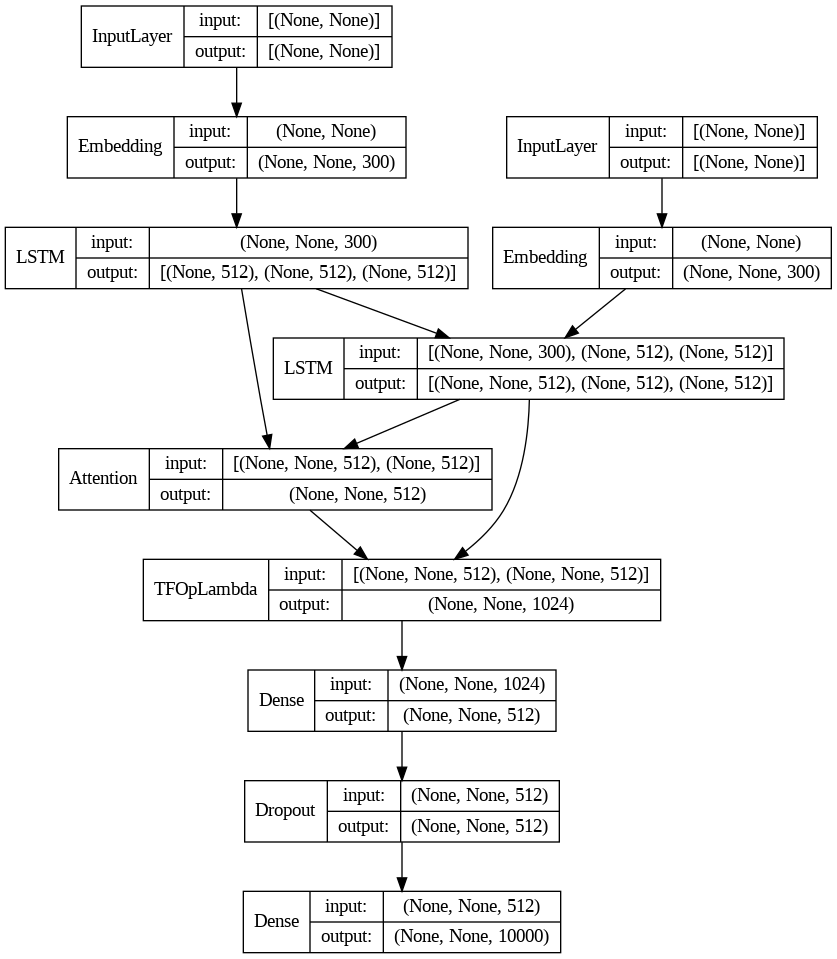

In [46]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session, concatenate

hidden_dim = 512  # Set hidden dimension for LSTM
embed_dim = 300  # Set embedding dimension

clear_session()

# Define an input sequence and process it
encoder_inputs = Input(shape=(None,), dtype='int32')  # Assuming integer encoding
encoder_inputs_emb = Embedding(input_dim=10000, output_dim=embed_dim, mask_zero=True)(encoder_inputs)  # input_dim: vocab size, output_dim: embedding size

# Define the encoder LSTM
encoder_outputs, state_h, state_c = LSTM(units=hidden_dim, return_state=True, dropout=0.5)(encoder_inputs_emb)
encoder_states = [state_h, state_c]

# Define the decoder, using encoder_states as initial state
decoder_inputs = Input(shape=(None,), dtype='int32')  # input sequence for decoder
decoder_inputs_emb = Embedding(input_dim=10000, output_dim=embed_dim, mask_zero=True)(decoder_inputs)  # Same vocab size for decoder

# Decoder LSTM
decoder_lstm = LSTM(units=hidden_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_emb, initial_state=encoder_states)

# Attention mechanism
attention = Attention()  # Simple dot product attention mechanism (Luong-style attention can be adjusted if needed)
attention_output = attention([decoder_outputs, encoder_outputs])  # Attention output from decoder and encoder

# Combine attention output with decoder outputs
decoder_outputs_attn = concatenate([attention_output, decoder_outputs])  # Concatenate attention and decoder outputs
attention_dense = Dense(units=hidden_dim, activation='tanh', use_bias=False)
decoder_outputs_combined = attention_dense(decoder_outputs_attn)

# Use a dense layer to classify each output as one of the words in the vocab
decoder_outputs_combined = Dropout(0.5)(decoder_outputs_combined)
decoder_dense = Dense(units=10000, activation='softmax')  # units: vocab size, softmax activation for classification
outputs = decoder_dense(decoder_outputs_combined)

# Define and visualize the end-to-end model
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True, show_layer_names=False)


In [47]:
# Tokenizer for the decoder labels
decoder_tokenizer = Tokenizer()
decoder_tokenizer.fit_on_texts(y_train)  # assuming 'y_train' is your list of target sentences

# Convert the target labels to integer indices
y_train_int = decoder_tokenizer.texts_to_sequences(y_train)
y_train_int = pad_sequences(y_train_int, padding='post')


In [49]:
desired_sequence_length = 50  # Set this to the maximum length of your sequences
y_train_int = pad_sequences(y_train_int, padding='post', maxlen=desired_sequence_length)


In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, concatenate
import numpy as np
import tensorflow as tf

# Define the encoder model for inference
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder state inputs
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder LSTM for inference
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_emb, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Attention mechanism
attention_output = attention([decoder_outputs, encoder_outputs])

# Concatenate the attention output with decoder outputs
decoder_outputs_attn = concatenate([attention_output, decoder_outputs])

# Dense layer after attention
decoder_outputs_combined = attention_dense(decoder_outputs_attn)

# Output layer for prediction
output = decoder_dense(decoder_outputs_combined)

# Decoder model for inference
decoder_model = Model([decoder_inputs] + decoder_states_inputs + [encoder_outputs], [output] + decoder_states)


In [86]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

def translate_sentence(input_seq, target=None):
    print('Source: ' + input_seq)
    if target is not None:
        print('Target: ' + target)

    # Tokenize the input sequence (ensure tokenizer is already defined)
    input_seq = tokenizer.texts_to_sequences([input_seq])

    # Pad the sequence to ensure it's of the correct length
    input_seq = pad_sequences(input_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    # Reshape input to 3D tensor (1, len(input_seq), 1)
    input_seq = input_seq.reshape(1, len(input_seq[0]), 1)

    # Encode the input sequence
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]

    # Initialize decoder's input with the start token (SOS token)
    dec_in = np.array([tokenizer.texts_to_sequences(['<SOS>'])[0]])  # Convert SOS to integer

    decoded_sentence = ''
    stop_condition = False
    max_decoding_steps = 30  # Max number of steps to prevent infinite loop

    while not stop_condition:
        # Prepare decoder input (this may need adjustment depending on your model's input expectations)
        decoder_input = [dec_in] + states_value + [encoder_outputs]

        try:
            # Pass the formatted inputs to the decoder model
            output_tokens, h, c = decoder_model.predict(decoder_input)
        except Exception as e:
            print(f"Error during prediction: {e}")
            break  # Exit the loop on error

        # Get the index of the token with the highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Map token index to word
        sampled_word = tokenizer.index_word.get(sampled_token_index, '<UNK>')  # Default to <UNK> if not found

        # Append the sampled word to the decoded sentence
        decoded_sentence += ' ' + sampled_word

        # Stop condition: either find the stop token (EOS) or exceed max length
        if sampled_word == '<EOS>' or len(decoded_sentence.split()) > max_decoding_steps:
            stop_condition = True

        # Update the next decoder input
        dec_in = np.array([sampled_token_index]).reshape(1, 1)

        # Update the decoder states
        states_value = [h, c]

    print('Translation: ' + decoded_sentence)
    print('****************************************************')

# Now you can call the function with your test data
translate_sentence(X_test.iloc[20], y_test.iloc[20])
translate_sentence(X_test.iloc[200], y_test.iloc[200])
translate_sentence(X_test.iloc[450], y_test.iloc[450])
translate_sentence(X_test.iloc[788], y_test.iloc[788])


Source: It is seven now.
Target: Il est sept heures.
1/1 [==============================] - 0s 32ms/step
Translation:  dessert irritate fortunate poorer hunger hunger hunger electric stick stick beef practiced draw rank farmer stick practiced rank farmer farmer assassinate predicted vocabulary crew vocabulary crew mondays chose closer communicating communicating
****************************************************
Source: Tom enjoyed talking to Mary.
Target: Tom a apprécié de parler à Mary.
1/1 [==============================] - 0s 28ms/step
Translation:  reference worship worship worship nation pledge pledge easily catastrophe died without puppet weekly puppet weekly puppet weekly puppet weekly puppet weekly weekly content content content chalk handles why's continues 0 0
****************************************************
Source: I want my key back.
Target: Je veux que vous me rendiez ma clé.
1/1 [==============================] - 0s 41ms/step
Translation:  prepared prepared abuse a